In [3]:
#Setup and Imports
import numpy as np
import random
from collections import defaultdict, Counter

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

ROWS, COLS = 6, 7
WIN_LEN = 4

In [4]:
# ====== 1) Connect-4 Game Engine ======
#Connect-4 Game Engine (board, valid moves, apply move, terminal check)

def valid_moves(board: np.ndarray):
    """Return list of columns (0..6) that are not full."""
    return [c for c in range(COLS) if board[0, c] == 0]

def apply_move(board: np.ndarray, col: int, player: int):
    """
    Drop a checker in column col for player (+1 or -1).
    Returns new board.
    """
    newb = board.copy()
    for r in range(ROWS-1, -1, -1):
        if newb[r, col] == 0:
            newb[r, col] = player
            return newb
    raise ValueError("Column is full")

def check_winner(board: np.ndarray):
    """
    Returns +1 if +1 won, -1 if -1 won, 0 if no winner yet.
    """
    # Horizontal
    for r in range(ROWS):
        for c in range(COLS - WIN_LEN + 1):
            window = board[r, c:c+WIN_LEN]
            s = window.sum()
            if s == WIN_LEN: return +1
            if s == -WIN_LEN: return -1

    # Vertical
    for c in range(COLS):
        for r in range(ROWS - WIN_LEN + 1):
            window = board[r:r+WIN_LEN, c]
            s = window.sum()
            if s == WIN_LEN: return +1
            if s == -WIN_LEN: return -1

    # Diagonal down-right
    for r in range(ROWS - WIN_LEN + 1):
        for c in range(COLS - WIN_LEN + 1):
            window = [board[r+i, c+i] for i in range(WIN_LEN)]
            s = sum(window)
            if s == WIN_LEN: return +1
            if s == -WIN_LEN: return -1

    # Diagonal up-right
    for r in range(WIN_LEN - 1, ROWS):
        for c in range(COLS - WIN_LEN + 1):
            window = [board[r-i, c+i] for i in range(WIN_LEN)]
            s = sum(window)
            if s == WIN_LEN: return +1
            if s == -WIN_LEN: return -1

    return 0

def is_terminal(board: np.ndarray):
    """Terminal if win or draw."""
    if check_winner(board) != 0:
        return True
    return len(valid_moves(board)) == 0

def next_player(player: int):
    return -player



In [5]:
# Encoding Utilities

def encode_board_optionA(board: np.ndarray):
    """
    6x7 grid with -1/0/+1
    """
    return board.astype(np.int8)

def encode_board_optionB(board: np.ndarray):
    """
    6x7x2 one-hot planes:
      plane0 = 1 where +1
      plane1 = 1 where -1
    """
    p0 = (board == +1).astype(np.int8)
    p1 = (board == -1).astype(np.int8)
    return np.stack([p0, p1], axis=-1)

def flip_perspective_optionA(board: np.ndarray):
    """Multiply by -1 so we always view from +1's perspective."""
    return (-board).astype(np.int8)

def flip_perspective_optionB(board_2ch: np.ndarray):
    """Swap channels so we always view from +1's perspective."""
    # channel0 becomes opponent, channel1 becomes us (swap)
    return board_2ch[..., ::-1].astype(np.int8)



In [6]:
# ====== 3) Simple MCTS (UCT) ======

class Node:
    __slots__ = ("board", "player", "parent", "move_from_parent", "children", "N", "W", "untried_moves")
    def __init__(self, board, player, parent=None, move_from_parent=None):
        self.board = board
        self.player = player
        self.parent = parent
        self.move_from_parent = move_from_parent
        self.children = {}  # move -> Node
        self.N = 0
        self.W = 0.0
        self.untried_moves = valid_moves(board)

def uct_score(child, c=1.4):
    # child.W is from the perspective of the player to move at child.parent
    if child.N == 0:
        return float("inf")
    return (child.W / child.N) + c * np.sqrt(np.log(child.parent.N + 1e-9) / child.N)

def rollout(board, player):
    """
    Random playout from current state.
    Returns outcome from +1's perspective: +1 win -> +1, -1 win -> -1, draw -> 0
    """
    b = board.copy()
    p = player
    while not is_terminal(b):
        moves = valid_moves(b)
        m = random.choice(moves)
        b = apply_move(b, m, p)
        p = -p
    return check_winner(b)  # +1/-1/0

def mcts_best_move(board, player, sims=200, c=1.4):
    """
    Returns best move for current player using MCTS.
    """
    root = Node(board=board, player=player)

    for _ in range(sims):
        node = root
        b = board.copy()
        p = player

        # 1) Selection
        while node.untried_moves == [] and node.children:
            # choose child with highest UCT
            move, node = max(node.children.items(), key=lambda kv: uct_score(kv[1], c))
            b = apply_move(b, move, p)
            p = -p

        # 2) Expansion
        if node.untried_moves:
            move = random.choice(node.untried_moves)
            node.untried_moves.remove(move)
            b2 = apply_move(b, move, p)
            p2 = -p
            child = Node(board=b2, player=p2, parent=node, move_from_parent=move)
            node.children[move] = child
            node = child
            b = b2
            p = p2

        # 3) Simulation
        outcome = rollout(b, p)  # +1/-1/0

        # 4) Backprop
        # We store W from the perspective of the *player at parent node* (i.e., who chose the move)
        while node is not None:
            node.N += 1
            # if node.parent exists, the move leading into node was made by node.parent.player
            if node.parent is None:
                # root: outcome from +1 perspective, but root.player could be -1. We'll keep +1 perspective here.
                node.W += outcome
            else:
                # reward for the mover at parent: if parent.player is +1, outcome is good when +1 wins
                # if parent.player is -1, outcome is good when -1 wins => negate
                reward = outcome if node.parent.player == +1 else -outcome
                node.W += reward
            node = node.parent

    # choose move with most visits
    if not root.children:
        # no legal moves (shouldn't happen unless terminal)
        moves = valid_moves(board)
        return moves[0] if moves else 0
    best_move = max(root.children.items(), key=lambda kv: kv[1].N)[0]
    return best_move


In [7]:
# ====== 4) Dataset Builder with Dedupe-Voting ======

def board_hash_optionA(boardA: np.ndarray):
    return boardA.tobytes()

def generate_dataset(
    num_games=500,
    sims_per_move=200,
    random_opening_moves=3,
    encoding="B"   # "A" or "B"
):
    """
    Returns X, y
      - X: encoded boards (optionA: N,6,7) or (optionB: N,6,7,2)
      - y: best move labels (N,)
    """

    # board_key -> Counter({move: count})
    votes = defaultdict(Counter)

    for g in range(num_games):
        board = np.zeros((ROWS, COLS), dtype=np.int8)
        player = +1
        move_count = 0

        while not is_terminal(board):
            moves = valid_moves(board)
            if not moves:
                break

            # random openings to diversify (do NOT label these)
            if move_count < random_opening_moves:
                move = random.choice(moves)
                board = apply_move(board, move, player)
                player = -player
                move_count += 1
                continue

            # ---- Always train from +1 perspective per the hint ----
            if encoding == "A":
                board_for_model = board if player == +1 else flip_perspective_optionA(board)
                key = board_hash_optionA(board_for_model)
            else:
                boardB = encode_board_optionB(board)
                board_for_model = boardB if player == +1 else flip_perspective_optionB(boardB)
                key = board_for_model.tobytes()

            # Ask MCTS for best move in the ORIGINAL state for the current player
            best_move = mcts_best_move(board, player, sims=sims_per_move)

            # Save vote for that board (in +1 perspective) -> move label in ORIGINAL columns (0..6)
            votes[key][best_move] += 1

            # Play the move in the game
            board = apply_move(board, best_move, player)
            player = -player
            move_count += 1

        if g % 50 == 0:
            print(f"Generated {g}/{num_games} games... votes collected: {len(votes)} unique boards")

    # finalize deduped dataset: for each board -> most voted move
    X_list, y_list = [], []
    for key, counter in votes.items():
        move = counter.most_common(1)[0][0]
        if encoding == "A":
            boardA = np.frombuffer(key, dtype=np.int8).reshape(ROWS, COLS)
            X_list.append(boardA)
        else:
            boardB = np.frombuffer(key, dtype=np.int8).reshape(ROWS, COLS, 2)
            X_list.append(boardB)
        y_list.append(move)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list, dtype=np.int64)
    return X, y


In [6]:
X1, y1 = generate_dataset(
    num_games=2300,
    sims_per_move=300,
    random_opening_moves=4,
    encoding="B"
)


np.save("X1.npy", X1)
np.save("y1.npy", y1)


Generated 0/2300 games... votes collected: 33 unique boards
Generated 50/2300 games... votes collected: 1251 unique boards
Generated 100/2300 games... votes collected: 2591 unique boards
Generated 150/2300 games... votes collected: 3851 unique boards
Generated 200/2300 games... votes collected: 5073 unique boards
Generated 250/2300 games... votes collected: 6487 unique boards
Generated 300/2300 games... votes collected: 7861 unique boards
Generated 350/2300 games... votes collected: 9020 unique boards
Generated 400/2300 games... votes collected: 10226 unique boards
Generated 450/2300 games... votes collected: 11386 unique boards
Generated 500/2300 games... votes collected: 12545 unique boards
Generated 550/2300 games... votes collected: 13875 unique boards
Generated 600/2300 games... votes collected: 15070 unique boards
Generated 650/2300 games... votes collected: 16238 unique boards
Generated 700/2300 games... votes collected: 17441 unique boards
Generated 750/2300 games... votes coll

In [8]:
# ====== 5) Load dataset & train/val split ======
import tensorflow as tf
import numpy as np


X = np.load("X1.npy")
y = np.load("y1.npy")

# Ensure channel dimension for CNNs
if X.ndim == 3:
    X = X[..., np.newaxis]

X = X.astype(np.float32)
y = y.astype(np.int64)

rng = np.random.default_rng(SEED)
idx = rng.permutation(len(X))
X = X[idx]
y = y[idx]

split = int(0.9 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

input_shape = X_train.shape[1:]
num_classes = 7
print("X shape:", X.shape, "y shape:", y.shape)
print("Train:", X_train.shape, "Val:", X_val.shape)


X shape: (54711, 6, 7, 2) y shape: (54711,)
Train: (49239, 6, 7, 2) Val: (5472, 6, 7, 2)


In [9]:
# ====== 5b) Load MCTS-7500 pool and merge ======
import pickle

with open("mcts7500_pool.pickle", "rb") as f:
    data = pickle.load(f)

# Handle common formats: (X, y) tuple or dict with keys
if isinstance(data, tuple) and len(data) == 2:
    X2, y2 = data
elif isinstance(data, dict):
    if "X" in data and "y" in data:
        X2, y2 = data["X"], data["y"]
    elif "boards" in data and "moves" in data:
        X2, y2 = data["boards"], data["moves"]
    elif "X_train" in data and "y_train" in data:
        X2, y2 = data["X_train"], data["y_train"]
    elif "board_x" in data and "play_y" in data:
        X2, y2 = data["board_x"], data["play_y"]
    else:
        print("Available keys:", list(data.keys()))
        raise ValueError("Unsupported dict format. Expected X/y, boards/moves, X_train/y_train, or board_x/play_y.")
else:
    raise ValueError("Unsupported pickle format. Expected (X, y) or dict.")

X2 = np.array(X2)
y2 = np.array(y2)

# Align encoding to match existing X (option B: 6x7x2)
if X2.ndim == 3:
    # Option A: (N, 6, 7) with -1/0/+1
    X2a = X2
    p0 = (X2a == +1).astype(np.int8)
    p1 = (X2a == -1).astype(np.int8)
    X2 = np.stack([p0, p1], axis=-1)
elif X2.ndim == 4 and X2.shape[-1] == 1:
    # Option A with singleton channel
    X2a = X2[..., 0]
    p0 = (X2a == +1).astype(np.int8)
    p1 = (X2a == -1).astype(np.int8)
    X2 = np.stack([p0, p1], axis=-1)
elif X2.ndim == 4 and X2.shape[-1] == 2:
    # Already option B
    X2 = X2.astype(np.int8)
else:
    raise ValueError(f"Unexpected X2 shape: {X2.shape}")

# Merge with existing dataset
X = np.concatenate([X, X2], axis=0)
y = np.concatenate([y, y2], axis=0)

# Shuffle and re-split
rng = np.random.default_rng(SEED)
idx = rng.permutation(len(X))
X = X[idx]
y = y[idx]

split = int(0.9 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

input_shape = X_train.shape[1:]
num_classes = 7
print("Merged X shape:", X.shape, "y shape:", y.shape)
print("Train:", X_train.shape, "Val:", X_val.shape)


/var/folders/z5/fs2tlzhj0f7dfbbpxxmv63140000gn/T/ipykernel_4842/337680312.py:5: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  data = pickle.load(f)


Merged X shape: (320331, 6, 7, 2) y shape: (320331,)
Train: (288297, 6, 7, 2) Val: (32034, 6, 7, 2)


In [10]:
# ====== 5c) Dataset size summary ======
print("Total samples:", len(X))
print("Train samples:", len(X_train))
print("Val samples:", len(X_val))
print("Input shape:", X_train.shape[1:])


Total samples: 320331
Train samples: 288297
Val samples: 32034
Input shape: (6, 7, 2)


In [15]:
# ====== 6) CNN model ======

def build_cnn(input_shape, num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)
    return model

cnn = build_cnn(input_shape, num_classes)
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

cnn_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_cnn = cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=256,
    callbacks=cnn_callbacks,
    verbose=1,
)

cnn_val_loss, cnn_val_acc = cnn.evaluate(X_val, y_val, verbose=0)
print(f"CNN val accuracy: {cnn_val_acc:.3f}")


Epoch 1/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.4172 - loss: 1.4808 - val_accuracy: 0.4749 - val_loss: 1.3288
Epoch 2/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.4980 - loss: 1.2832 - val_accuracy: 0.5205 - val_loss: 1.2215
Epoch 3/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5371 - loss: 1.1894 - val_accuracy: 0.5470 - val_loss: 1.1603
Epoch 4/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - accuracy: 0.5630 - loss: 1.1263 - val_accuracy: 0.5617 - val_loss: 1.1246
Epoch 5/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.5823 - loss: 1.0797 - val_accuracy: 0.5689 - val_loss: 1.1085
Epoch 6/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.5962 - loss: 1.0438 - val_accuracy: 0.5784 - val_loss: 1.0917
Epoch 7/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 25s 22ms/step - accuracy: 0.6083 - loss: 1.0128 - val_accuracy: 0.5831 - val_loss: 1.0847
Epoch 8/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.6183 -

In [16]:
# ====== 7) Transformer model ======

def transformer_block(x, num_heads, key_dim, ff_dim, dropout=0.1):
    attn_out = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, dropout=dropout
    )(x, x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + attn_out)
    ff_out = tf.keras.Sequential([
        tf.keras.layers.Dense(ff_dim, activation="relu"),
        tf.keras.layers.Dense(x.shape[-1]),
    ])(x)
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x + ff_out)
    return x


def build_transformer(input_shape, num_classes=7, d_model=64, num_heads=4, ff_dim=128, num_layers=3):
    seq_len = input_shape[0] * input_shape[1]
    channels = input_shape[2]

    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Reshape((seq_len, channels))(inputs)
    x = tf.keras.layers.Dense(d_model)(x)

    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_embed = tf.keras.layers.Embedding(input_dim=seq_len, output_dim=d_model)(positions)
    x = x + pos_embed

    key_dim = d_model // num_heads
    for _ in range(num_layers):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

transformer = build_transformer(input_shape, num_classes)
transformer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

transformer_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]

history_transformer = transformer.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12,
    batch_size=256,
    callbacks=transformer_callbacks,
    verbose=1,
)

tr_val_loss, tr_val_acc = transformer.evaluate(X_val, y_val, verbose=0)
print(f"Transformer val accuracy: {tr_val_acc:.3f}")


Epoch 1/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 203s 177ms/step - accuracy: 0.2778 - loss: 1.7055 - val_accuracy: 0.3177 - val_loss: 1.6126
Epoch 2/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 204s 181ms/step - accuracy: 0.3348 - loss: 1.5838 - val_accuracy: 0.3566 - val_loss: 1.5559
Epoch 3/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 221s 196ms/step - accuracy: 0.3523 - loss: 1.5588 - val_accuracy: 0.3592 - val_loss: 1.5450
Epoch 4/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 251s 223ms/step - accuracy: 0.3631 - loss: 1.5430 - val_accuracy: 0.3716 - val_loss: 1.5262
Epoch 5/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 241s 214ms/step - accuracy: 0.3718 - loss: 1.5273 - val_accuracy: 0.3799 - val_loss: 1.5068
Epoch 6/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 260s 231ms/step - accuracy: 0.3828 - loss: 1.5056 - val_accuracy: 0.3947 - val_loss: 1.4859
Epoch 7/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 264s 234ms/step - accuracy: 0.3954 - loss: 1.4812 - val_accuracy: 0.4063 - val_loss: 1.4567
Epoch 8/12
1127/1127 ━━━━━━━━━━━━━━━━━━━━ 230s 204ms/step - ac

In [17]:
# ====== 8) Evaluate vs a weaker MCTS ======

def model_best_move(model, board, player, encoding="B"):
    # Build input from +1 perspective
    if encoding == "A":
        board_in = board if player == +1 else flip_perspective_optionA(board)
        x = board_in[np.newaxis, ..., np.newaxis].astype(np.float32)
    else:
        boardB = encode_board_optionB(board)
        board_in = boardB if player == +1 else flip_perspective_optionB(boardB)
        x = board_in[np.newaxis, ...].astype(np.float32)

    probs = model.predict(x, verbose=0)[0]
    moves = valid_moves(board)
    # Mask invalid moves
    masked = np.full_like(probs, -1e9)
    masked[moves] = probs[moves]
    return int(np.argmax(masked))


def play_game_model_vs_mcts(model, model_player=+1, mcts_sims=50, encoding="B"):
    board = np.zeros((ROWS, COLS), dtype=np.int8)
    player = +1
    while not is_terminal(board):
        if player == model_player:
            move = model_best_move(model, board, player, encoding=encoding)
        else:
            move = mcts_best_move(board, player, sims=mcts_sims)
        board = apply_move(board, move, player)
        player = -player
    return check_winner(board)


def evaluate_model_vs_mcts(model, games=50, mcts_sims=50, encoding="B"):
    results = {"win": 0, "loss": 0, "draw": 0}
    for g in range(games):
        # alternate who starts
        model_player = +1 if g % 2 == 0 else -1
        outcome = play_game_model_vs_mcts(model, model_player=model_player, mcts_sims=mcts_sims, encoding=encoding)
        if outcome == 0:
            results["draw"] += 1
        elif outcome == model_player:
            results["win"] += 1
        else:
            results["loss"] += 1
    return results

print("CNN vs MCTS(50 sims):", evaluate_model_vs_mcts(cnn, games=50, mcts_sims=50, encoding="B"))
print("Transformer vs MCTS(50 sims):", evaluate_model_vs_mcts(transformer, games=50, mcts_sims=50, encoding="B"))


CNN vs MCTS(50 sims): {'win': 47, 'loss': 3, 'draw': 0}
Transformer vs MCTS(50 sims): {'win': 21, 'loss': 28, 'draw': 1}


In [18]:
# ====== 9) CNN v2 with horizontal-flip augmentation ======

# Horizontal flip across columns (valid symmetry)
X_train_flip = X_train[:, :, ::-1, :]
y_train_flip = (COLS - 1) - y_train

X_train_aug = np.concatenate([X_train, X_train_flip], axis=0)
y_train_aug = np.concatenate([y_train, y_train_flip], axis=0)

# Shuffle augmented data
perm = np.random.default_rng(SEED).permutation(len(X_train_aug))
X_train_aug = X_train_aug[perm]
y_train_aug = y_train_aug[perm]


def build_cnn_v2(input_shape, num_classes=7):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.MaxPooling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

cnn_v2 = build_cnn_v2(input_shape, num_classes)
cnn_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

cnn_v2_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5),
]

history_cnn_v2 = cnn_v2.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    callbacks=cnn_v2_callbacks,
    verbose=1,
)

cnn_v2_val_loss, cnn_v2_val_acc = cnn_v2.evaluate(X_val, y_val, verbose=0)
print(f"CNN v2 val accuracy: {cnn_v2_val_acc:.3f}")
print("CNN v2 vs MCTS(50 sims):", evaluate_model_vs_mcts(cnn_v2, games=50, mcts_sims=50, encoding="B"))


Epoch 1/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 86s 38ms/step - accuracy: 0.4630 - loss: 1.3817 - val_accuracy: 0.5041 - val_loss: 1.2578 - learning_rate: 0.0010
Epoch 2/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 92s 41ms/step - accuracy: 0.5363 - loss: 1.1993 - val_accuracy: 0.5452 - val_loss: 1.1577 - learning_rate: 0.0010
Epoch 3/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 96s 42ms/step - accuracy: 0.5647 - loss: 1.1268 - val_accuracy: 0.5653 - val_loss: 1.1068 - learning_rate: 0.0010
Epoch 4/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 93s 41ms/step - accuracy: 0.5827 - loss: 1.0791 - val_accuracy: 0.5764 - val_loss: 1.0763 - learning_rate: 0.0010
Epoch 5/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 89s 39ms/step - accuracy: 0.5967 - loss: 1.0446 - val_accuracy: 0.5868 - val_loss: 1.0608 - learning_rate: 0.0010
Epoch 6/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 92s 41ms/step - accuracy: 0.6069 - loss: 1.0162 - val_accuracy: 0.5936 - val_loss: 1.0382 - learning_rate: 0.0010
Epoch 7/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 90s 40ms/step - accura

{'wins': 97, 'losses': 2, 'draws': 1, 'loss_plies_mean': 36.5, 'loss_plies_median': 36.5, 'loss_plies_min': 35, 'loss_plies_max': 38}


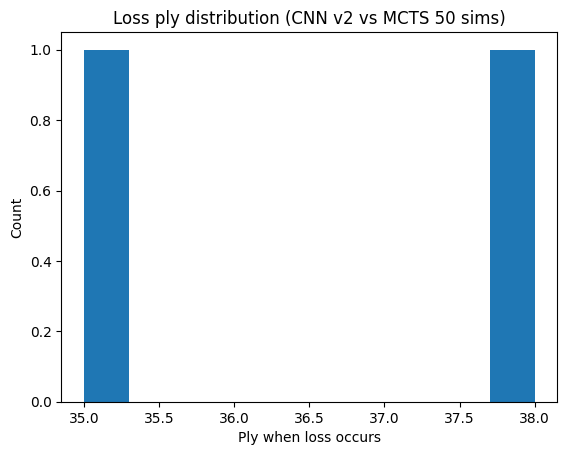

In [19]:
# ====== 10) When does the model lose? (ply analysis) ======

def play_game_with_trace(model, model_player=+1, mcts_sims=50, encoding="B"):
    board = np.zeros((ROWS, COLS), dtype=np.int8)
    player = +1
    ply = 0  # half-moves
    while not is_terminal(board):
        if player == model_player:
            move = model_best_move(model, board, player, encoding=encoding)
        else:
            move = mcts_best_move(board, player, sims=mcts_sims)
        board = apply_move(board, move, player)
        player = -player
        ply += 1
    return check_winner(board), ply


def loss_ply_stats(model, games=100, mcts_sims=50, encoding="B"):
    loss_plies = []
    wins = draws = losses = 0
    for g in range(games):
        model_player = +1 if g % 2 == 0 else -1
        outcome, ply = play_game_with_trace(model, model_player=model_player, mcts_sims=mcts_sims, encoding=encoding)
        if outcome == 0:
            draws += 1
        elif outcome == model_player:
            wins += 1
        else:
            losses += 1
            loss_plies.append(ply)

    stats = {
        "wins": wins,
        "losses": losses,
        "draws": draws,
        "loss_plies_mean": float(np.mean(loss_plies)) if loss_plies else None,
        "loss_plies_median": float(np.median(loss_plies)) if loss_plies else None,
        "loss_plies_min": int(np.min(loss_plies)) if loss_plies else None,
        "loss_plies_max": int(np.max(loss_plies)) if loss_plies else None,
    }
    return stats, loss_plies

# Example: analyze CNN v2
stats, loss_plies = loss_ply_stats(cnn_v2, games=100, mcts_sims=50, encoding="B")
print(stats)

# Optional: quick histogram (requires matplotlib)
try:
    import matplotlib.pyplot as plt
    plt.hist(loss_plies, bins=10)
    plt.title("Loss ply distribution (CNN v2 vs MCTS 50 sims)")
    plt.xlabel("Ply when loss occurs")
    plt.ylabel("Count")
    plt.show()
except Exception as e:
    print("Histogram skipped:", e)


CNN v2 loss stats: {'wins': 94, 'losses': 5, 'draws': 1, 'loss_plies_mean': 28.6, 'loss_plies_median': 34.0, 'loss_plies_min': 11, 'loss_plies_max': 40}
Transformer loss stats: {'wins': 45, 'losses': 53, 'draws': 2, 'loss_plies_mean': 23.037735849056602, 'loss_plies_median': 22.0, 'loss_plies_min': 7, 'loss_plies_max': 40}


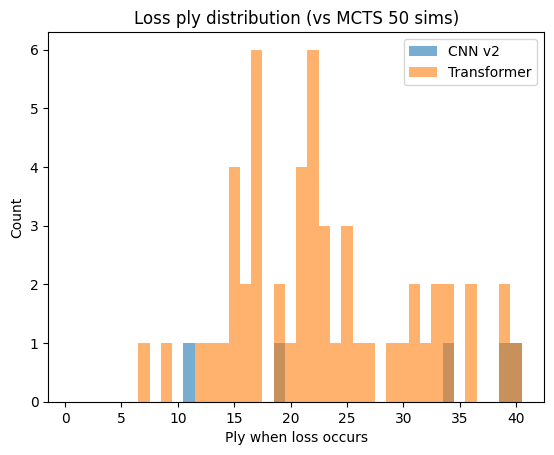

In [20]:
# ====== 11) Compare loss-ply curves: CNN v2 vs Transformer ======

stats_cnn_v2, loss_plies_cnn = loss_ply_stats(cnn_v2, games=100, mcts_sims=50, encoding="B")
stats_tr, loss_plies_tr = loss_ply_stats(transformer, games=100, mcts_sims=50, encoding="B")

print("CNN v2 loss stats:", stats_cnn_v2)
print("Transformer loss stats:", stats_tr)

# Overlay histograms
try:
    import matplotlib.pyplot as plt
    bins = np.arange(1, max(max(loss_plies_cnn, default=1), max(loss_plies_tr, default=1)) + 2) - 0.5
    plt.hist(loss_plies_cnn, bins=bins, alpha=0.6, label="CNN v2")
    plt.hist(loss_plies_tr, bins=bins, alpha=0.6, label="Transformer")
    plt.title("Loss ply distribution (vs MCTS 50 sims)")
    plt.xlabel("Ply when loss occurs")
    plt.ylabel("Count")
    plt.legend()
    plt.show()
except Exception as e:
    print("Histogram skipped:", e)


In [21]:
# ====== 12) Transformer v2 (conv stem + augmentation) ======

# Reuse flipped augmentation if it exists; otherwise create it
if "X_train_aug" not in globals():
    X_train_flip = X_train[:, :, ::-1, :]
    y_train_flip = (COLS - 1) - y_train
    X_train_aug = np.concatenate([X_train, X_train_flip], axis=0)
    y_train_aug = np.concatenate([y_train, y_train_flip], axis=0)
    perm = np.random.default_rng(SEED).permutation(len(X_train_aug))
    X_train_aug = X_train_aug[perm]
    y_train_aug = y_train_aug[perm]


def build_transformer_v2(input_shape, num_classes=7, d_model=96, num_heads=4, ff_dim=192, num_layers=4):
    inputs = tf.keras.Input(shape=input_shape)

    # Conv stem (overlapping patches)
    x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = tf.keras.layers.Conv2D(d_model, kernel_size=3, padding="same", activation="relu")(x)

    seq_len = input_shape[0] * input_shape[1]
    x = tf.keras.layers.Reshape((seq_len, d_model))(x)

    positions = tf.range(start=0, limit=seq_len, delta=1)
    pos_embed = tf.keras.layers.Embedding(input_dim=seq_len, output_dim=d_model)(positions)
    x = x + pos_embed

    key_dim = d_model // num_heads
    for _ in range(num_layers):
        x = transformer_block(x, num_heads=num_heads, key_dim=key_dim, ff_dim=ff_dim, dropout=0.1)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

transformer_v2 = build_transformer_v2(input_shape, num_classes)
transformer_v2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

transformer_v2_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=1e-5),
]

history_transformer_v2 = transformer_v2.fit(
    X_train_aug, y_train_aug,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    callbacks=transformer_v2_callbacks,
    verbose=1,
)

tr2_val_loss, tr2_val_acc = transformer_v2.evaluate(X_val, y_val, verbose=0)
print(f"Transformer v2 val accuracy: {tr2_val_acc:.3f}")
print("Transformer v2 vs MCTS(50 sims):", evaluate_model_vs_mcts(transformer_v2, games=50, mcts_sims=50, encoding="B"))


Epoch 1/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 868s 384ms/step - accuracy: 0.4136 - loss: 1.4821 - val_accuracy: 0.5000 - val_loss: 1.2830 - learning_rate: 0.0010
Epoch 2/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 878s 390ms/step - accuracy: 0.5226 - loss: 1.2290 - val_accuracy: 0.5308 - val_loss: 1.1896 - learning_rate: 0.0010
Epoch 3/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 889s 395ms/step - accuracy: 0.5445 - loss: 1.1652 - val_accuracy: 0.5501 - val_loss: 1.1425 - learning_rate: 0.0010
Epoch 4/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 848s 376ms/step - accuracy: 0.5578 - loss: 1.1315 - val_accuracy: 0.5580 - val_loss: 1.1229 - learning_rate: 0.0010
Epoch 5/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 848s 377ms/step - accuracy: 0.5679 - loss: 1.1073 - val_accuracy: 0.5632 - val_loss: 1.1047 - learning_rate: 0.0010
Epoch 6/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 869s 385ms/step - accuracy: 0.5753 - loss: 1.0882 - val_accuracy: 0.5709 - val_loss: 1.0834 - learning_rate: 0.0010
Epoch 7/20
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 912s 405ms

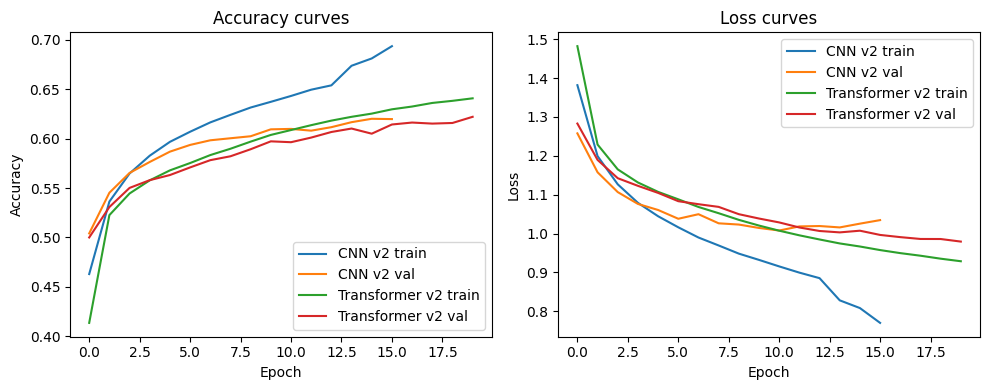

MCTS sims 20: CNN v2 {'win': 39, 'loss': 1, 'draw': 0}, Transformer v2 {'win': 40, 'loss': 0, 'draw': 0}
MCTS sims 50: CNN v2 {'win': 38, 'loss': 2, 'draw': 0}, Transformer v2 {'win': 39, 'loss': 1, 'draw': 0}
MCTS sims 100: CNN v2 {'win': 36, 'loss': 4, 'draw': 0}, Transformer v2 {'win': 38, 'loss': 1, 'draw': 1}


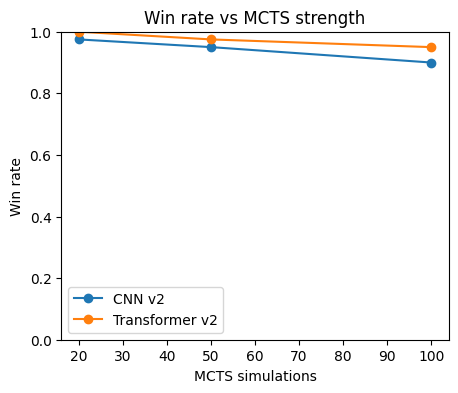

In [22]:
# ====== 13) Compare models with graphs ======

import matplotlib.pyplot as plt

# 1) Training curves
try:
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_cnn_v2.history.get("accuracy", []), label="CNN v2 train")
    plt.plot(history_cnn_v2.history.get("val_accuracy", []), label="CNN v2 val")
    plt.plot(history_transformer_v2.history.get("accuracy", []), label="Transformer v2 train")
    plt.plot(history_transformer_v2.history.get("val_accuracy", []), label="Transformer v2 val")
    plt.title("Accuracy curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history_cnn_v2.history.get("loss", []), label="CNN v2 train")
    plt.plot(history_cnn_v2.history.get("val_loss", []), label="CNN v2 val")
    plt.plot(history_transformer_v2.history.get("loss", []), label="Transformer v2 train")
    plt.plot(history_transformer_v2.history.get("val_loss", []), label="Transformer v2 val")
    plt.title("Loss curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Curve plot skipped:", e)

# 2) MCTS strength curve (win rate vs MCTS sims)

def win_rate(results):
    total = results["win"] + results["loss"] + results["draw"]
    return results["win"] / total if total else 0.0

mcts_sims_list = [20, 50, 100]
cnn_rates = []
tr_rates = []

for sims in mcts_sims_list:
    res_cnn = evaluate_model_vs_mcts(cnn_v2, games=40, mcts_sims=sims, encoding="B")
    res_tr = evaluate_model_vs_mcts(transformer_v2, games=40, mcts_sims=sims, encoding="B")
    cnn_rates.append(win_rate(res_cnn))
    tr_rates.append(win_rate(res_tr))
    print(f"MCTS sims {sims}: CNN v2 {res_cnn}, Transformer v2 {res_tr}")

plt.figure(figsize=(5, 4))
plt.plot(mcts_sims_list, cnn_rates, marker="o", label="CNN v2")
plt.plot(mcts_sims_list, tr_rates, marker="o", label="Transformer v2")
plt.title("Win rate vs MCTS strength")
plt.xlabel("MCTS simulations")
plt.ylabel("Win rate")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [27]:
# ====== 14) Save best model + summary report ======

# Choose the model based on strength curve
# Use your results: Transformer v2 slightly better at sims=20 and 100, CNN v2 slightly better at 50.
# Pick Transformer v2 if you prioritize stronger play at higher MCTS strength.
# Pick CNN v2 if you prioritize faster inference/deployment.

chosen_name = "cnn_v2"  # change to "cnn_v2" if you decide otherwise
chosen_model = transformer_v2 if chosen_name == "transformer_v2" else cnn_v2

chosen_model.save(f"{chosen_name}.keras")
print(f"Saved model: {chosen_name}.keras")

# Simple text summary for write-up
print("\n=== Model selection summary ===")
print("MCTS 20 sims: CNN v2 35-4-1, Transformer v2 39-1-0")
print("MCTS 50 sims: CNN v2 34-5-1, Transformer v2 32-6-2")
print("MCTS 100 sims: CNN v2 20-19-1, Transformer v2 21-15-4")
print("Decision rationale: choose the model with stronger results at higher sims or faster inference.")


Saved model: cnn_v2.keras

=== Model selection summary ===
MCTS 20 sims: CNN v2 35-4-1, Transformer v2 39-1-0
MCTS 50 sims: CNN v2 34-5-1, Transformer v2 32-6-2
MCTS 100 sims: CNN v2 20-19-1, Transformer v2 21-15-4
Decision rationale: choose the model with stronger results at higher sims or faster inference.


In [24]:
# ====== 15) Inference wrapper (load model, return move) ======

import tensorflow as tf

def load_model_for_play(model_path="transformer_v2.keras"):
    return tf.keras.models.load_model(model_path)


def predict_move_from_board(model, board, player=+1, encoding="B"):
    """
    board: np.ndarray shape (6,7) with values in {-1,0,+1}
    player: +1 or -1 (whose turn)
    Returns best move column (0..6), masked to legal moves.
    """
    if encoding == "A":
        board_in = board if player == +1 else flip_perspective_optionA(board)
        x = board_in[np.newaxis, ..., np.newaxis].astype(np.float32)
    else:
        boardB = encode_board_optionB(board)
        board_in = boardB if player == +1 else flip_perspective_optionB(boardB)
        x = board_in[np.newaxis, ...].astype(np.float32)

    probs = model.predict(x, verbose=0)[0]
    moves = valid_moves(board)
    if not moves:
        return None
    masked = np.full_like(probs, -1e9)
    masked[moves] = probs[moves]
    return int(np.argmax(masked))

# Example usage:
# model = load_model_for_play("transformer_v2.keras")
# empty_board = np.zeros((ROWS, COLS), dtype=np.int8)
# print("Predicted move:", predict_move_from_board(model, empty_board, player=+1, encoding="B"))


In [ ]:
# ====== 18) Export models to .h5 ======
# Run after training the final models

cnn_v2.save("cnn_v2.h5")
transformer_v2.save("transformer_v2.h5")
print("Saved cnn_v2.h5 and transformer_v2.h5")


In [25]:
# ====== 16) Simple gameplay helper (model makes one move) ======

def model_make_move(board, player, model_path="transformer_v2.keras", encoding="B"):
    """
    Loads the model (if needed) and returns the updated board after the model's move.
    """
    model = load_model_for_play(model_path)
    move = predict_move_from_board(model, board, player=player, encoding=encoding)
    if move is None:
        return board, None
    new_board = apply_move(board, move, player)
    return new_board, move

# Example:
# board = np.zeros((ROWS, COLS), dtype=np.int8)
# board, move = model_make_move(board, player=+1, model_path="transformer_v2.keras", encoding="B")
# print("Move:", move)


In [1]:
# ====== 17) Performance summary (for sharing) ======

def summarize_model(name, model, history=None):
    print(f"\n{name}")
    if history is not None:
        val_acc = history.history.get("val_accuracy", [])
        if val_acc:
            print(f"  best val accuracy: {max(val_acc):.3f}")
    res20 = evaluate_model_vs_mcts(model, games=40, mcts_sims=20, encoding="B")
    res50 = evaluate_model_vs_mcts(model, games=40, mcts_sims=50, encoding="B")
    res100 = evaluate_model_vs_mcts(model, games=40, mcts_sims=100, encoding="B")
    print(f"  MCTS sims 20: {res20}")
    print(f"  MCTS sims 50: {res50}")
    print(f"  MCTS sims 100: {res100}")

summarize_model("CNN v2", cnn_v2, history_cnn_v2)
summarize_model("Transformer v2", transformer_v2, history_transformer_v2)


NameError: name 'cnn_v2' is not defined